# INCIDENCIA DEL CANCER A NIVEL GLOBAL Y EUROPA

Fernando Moro Cordobés

## Introducción

El cáncer constituye una de las principales causas de mortalidad en los seres humanos. Recientemente se ha puesto de manifiesto que el número de personas diagnosticadas con algún tipo de cáncer ha [incrementado a nivel global](https://www.infobae.com/salud/2025/02/05/aumentan-los-casos-de-cancer-en-menores-de-50-anos-la-ciencia-busca-las-razones/).

Más allá de la búsqueda de nuevos métodos de diagnosis y terapias, el análisis de los datos de la enfermedad en las distintas zonas del planeta contribuye al estudio relacional de los factores diferenciales en aquellas poblaciones donde existe mayor incidencia. Además, arroja una imagen de aquellos lugares donde es más necesaria la financiación de la atención oncológica y paliativa.

El proyecto [_Cancer Incidence in Five continents_ (CI5)](https://ci5.iarc.fr/ci5plus/)  es una colaboración entre _International Agency for Research on Cancer_ y _International Association of Cancer Registries_ cuyo objetivo es recopilar los datos de incidencia del cáncer en distintos países a lo largo del tiempo. En este trabajo se ha utilizado el dataset del proyecto CI5 para realizar una comparativa del número de casos detectados a lo largo de los últimos años en los distintos continentes. Además se han analizado datos a nivel del continente europeo, profundizando en aquellos países donde el número de casos fue más alto.

Para cada región, el número de casos para un tipo de cáncer específico es expresado como el número de casos por cada 100000 habitantes. En el dataset original existen regiones diferentes para un mismo país. Como no conocemos los habitantes de cada región no podemos hacer un promedio ponderado de los casos, así que vamos a trabajar con el número de casos acumulados para reflejar la carga total de la enfermedad en distintas resoluciones espaciales.

## Código y Resultados

### Importación y preparación del dataset inicial

In [184]:
# Importamos las librerias necesarias

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# plotly
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

# word cloud library
from wordcloud import WordCloud


# Cargamos el data set original
cancer_total = pd.read_csv("data.csv", sep = ",")

# Cargamos el data set con los paises y continentes
countries = pd.read_csv("id_dict.csv", sep = ",")

# Cargamos el data set con los tipos de cancer
cancer_kind = pd.read_csv("cancer_dict.csv", sep = ",")

cancer_total.head(10)

,id_code,sex,cancer_code,age,cases,py,year
0,80000299,1,1,1,30,96307.0,1993
1,80000299,1,1,2,18,66677.0,1993
2,80000299,1,1,3,11,59556.0,1993
3,80000299,1,1,4,8,60462.0,1993
4,80000299,1,1,5,30,72770.0,1993
5,80000299,1,1,6,46,64952.0,1993
6,80000299,1,1,7,58,45156.0,1993
7,80000299,1,1,8,37,28283.0,1993
8,80000299,1,1,9,28,18323.0,1993
9,80000299,1,1,10,21,12196.0,1993


In [185]:
""" 
Primero, sustituimos introducimos una columna con el nombre del país dentro del dataFrame de countries
a partir del country code. Utilizamos para ello un csv que contiene los valores asociados a cada pais. 
La finalidad de esto es lograr una columna con el nombre del país nada más
"""

# Cargamos el csv nuevo (https://github.com/lukes/ISO-3166-Countries-with-Regional-Codes/blob/master/all/all.csv)

paises_codigo = pd.read_csv("country_3digit_code.csv", sep = ",")

# Unimos el dataFrame countries con el nuevo mediante la columna del código

countries_combined = pd.merge(countries, paises_codigo, left_on="country_code", right_on="country-code")
# countries_combined.head()

# Conservamos las columnas de id_code (para combinar con el dataFrame de cancer total),
# la columna name(el nombre del pais) y la columna region (el continente)

countries_definitivo = countries_combined[["id_code", "name", "region"]]

# Creacion de una serie con el índice de los valores que aparecen en dataframe de cancer total
# y los rangos etarios correspondientes

df_edad = pd.DataFrame({"edad": ["0-4",  "5-9", "10-14",
                                 "15-19", "20-24", "25-29",
                                 "30-34","35-39", "40-44", 
                                 "45-49","50-54", "55-59",
                                "60-64", "65-69", "70-74",
                                "75-79", "80-85", "85+"]},
                                 index=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18])

# Tambien creamos una serie con el sexo

sexo = pd.DataFrame({"sexo":["Hombre", "Mujer"]}, index=[1,2])

""" 
A partir de aquí vamos a concatenar los nombres de países, continentes, tipos de cancer, rangos de edad y el sexo en 
el dataFrame de cancer total. La finalidad de esto es poner más clara la información, sin que esté codificada.
Esto facilitará su entendimiento y estudio
"""
# concatenamos información de paises
cancer_total_contries = pd.merge(cancer_total, countries_definitivo, on="id_code")

# concatenamos información de tipos de cáncer
cancer_total_contries_tipos = pd.merge(cancer_total_contries, cancer_kind, on="cancer_code")

# concatenmos rangos etarios
cancer_total_contries_tipos_edad = pd.merge(cancer_total_contries_tipos, df_edad, left_on="age", right_index=True)

# concatenamos sexo
cancer_total_contries_tipos_edad_sexo = pd.merge(cancer_total_contries_tipos_edad, sexo, left_on="sex", right_index=True)

# Establecemos el dataFrame definitivo con las columnas de nuestro interés
""" 
cases: número de casos diagnosticados
year: año
name: país
region: continente
cancer_label: tipo de cancer
edad: rango de edad de pacientes
sexo: sexo biológico
"""
cancer_def = cancer_total_contries_tipos_edad_sexo[["cases", "year", "name", "region", "cancer_label", "edad", "sexo"]]

# Vamos a Excluir las filas correspondientes a el valor "All cancers excluding non-melanoma skin" dentro de la columna cancer_label.
# Este valor incluye varios tipos de cánceres, y sólo queremos trabajar con categorias bien definidas.

cancer_def = cancer_def[cancer_def["cancer_label"] != "All cancers excluding non-melanoma skin"]

# Comprobamos que no hay valores faltantes
cancer_def.isna().sum()

# Estudiamos las dimensiones del dataFrame final y el tipo de dato que contiene cada columna
cancer_def.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21884148 entries, 19 to 23236618
Data columns (total 7 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   cases         int64 
 1   year          int64 
 2   name          object
 3   region        object
 4   cancer_label  object
 5   edad          object
 6   sexo          object
dtypes: int64(2), object(5)
memory usage: 1.3+ GB


In [186]:
# Vamos a generar una columna nueva con la cantidad de paises de los que existe información
# para cada continente y para cada año.

numero_de_paises_por_año_por_continente = cancer_def.groupby(["region","year"])["name"].unique().reset_index()

numero_de_paises_por_año_por_continente["cantidad_paises"] = numero_de_paises_por_año_por_continente["name"].apply(len)

# Me quedo solo con un dataFrame que tenga la información de continente - año - cantidad de paises proveedores de datos

numero_paises_proveedores = numero_de_paises_por_año_por_continente[["region", "year", "cantidad_paises"]]
numero_paises_proveedores

,region,year,cantidad_paises
0,Africa,1993,1
1,Africa,1994,1
2,Africa,1995,1
3,Africa,1996,1
4,Africa,1997,1
...,...,...,...
225,Oceania,2013,2
226,Oceania,2014,2
227,Oceania,2015,2
228,Oceania,2016,2


### Análisis de los datos a nivel de continente

Pregunta 1. Existen diferencias entre los continentes respecto al número de casos diagnosticados de 
diferentes tipos de cáncer.

Hipótesis: El número de casos de cáncer diagnosticados difiere entre los continentes a lo largo de los años.

#### Métodos y resultados

1) Cálculo del periodo donde existen datos de al meos un país para los 5 continentes

In [187]:
# Para poner a prueba la hipótesis primero comprobamos para que periodo de tiempo
# existen datos para todos los continentes
pd.set_option('display.max_columns', None)
tabla = cancer_def.groupby(["region", "year"])[["cases"]].count().unstack()
tabla.isna().sum().unstack()

# Creamos un nuevo dataFrame con el periodo de tiempo entre 1993-2017:

cancer_93_17 = cancer_def[cancer_def["year"] >= 1993]

Con eso comprobamos que el periodo para el que existen datos para todos los continentes es desde 1993 hasta 2017, por lo que trabajaremos con ese periodo.

2) Estudiamos los tipos de cáncer que acumulan mayor número de casos para cada continente en el periodo 1993-2017

In [188]:
# Creamos un dataFrame con los cánceres que acumulan un mayor número de casos en los 5 continentes a
# lo largo del periodo 1993-2017
tumores_mas_comunes = cancer_93_17.groupby("cancer_label")[["cases"]].sum().sort_values(by="cases", ascending=False).reset_index()
tumores_mas_comunes.head(5)

tumores_mas_comunes["cancer_label"] = tumores_mas_comunes["cancer_label"].replace({"Lung": "Pulmón",
                                                                     "Breast":"Pecho", "Prostate": "Próstata",
                                                                     "Bladder": "Vejiga"})

# Cambiamos el nombre al castellano de los tipos de cáncer más comunes para que se pueda ver bien en el gráfico

cancer_93_17["cancer_label"] = cancer_93_17["cancer_label"].replace({"Lung": "Pulmón",
                                                                     "Breast":"Pecho", "Prostate": "Próstata",
                                                                     "Bladder": "Vejiga"})

tumores_mas_comunes


C:\Users\ferna\AppData\Local\Temp\ipykernel_7332\2766446274.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,cancer_label,cases
0,Pulmón,26926226
1,Pecho,14015528
2,Próstata,12771689
3,Vejiga,8642728
4,Colon,7443348
5,Thyroid,5462162
6,Corpus uteri,5328905
7,Liver,4184982
8,Melanoma of skin,3859782
9,Non-Hodgkin lymphoma,3657172


Text(0, 0.5, 'Casos acumulados/100.000 hab')

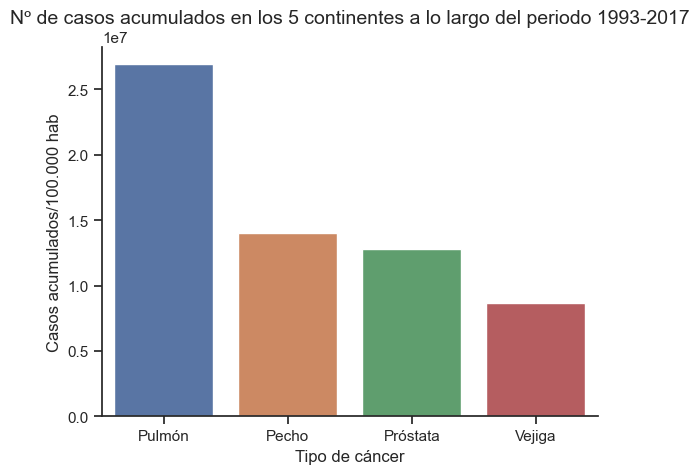

In [189]:
# Representación gráfica de los tipos de cánceres que mayor número de casos acumulan en los 5 continentes 
# a lo largo del periodo 1993-2017
canceres_mayoritarios = tumores_mas_comunes.iloc[:4]

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
sns.barplot(x=canceres_mayoritarios["cancer_label"], y= canceres_mayoritarios["cases"], hue = canceres_mayoritarios["cancer_label"])
plt.title("Nº de casos acumulados en los 5 continentes a lo largo del periodo 1993-2017", fontsize=14)
plt.xlabel("Tipo de cáncer", fontsize=12)
plt.ylabel("Casos acumulados/100.000 hab", fontsize=12)

Comprobamos que a nivel de los 5 continentes, los tipos de cáncer que mayor número de casos acumulan
son el cáncer de pulmón, pecho, próstata y vejiga.

In [190]:
## Creamos un data frame con los casos para los canceres con mayor número de casos:
# Lung, Breast, Prostate y Bladder

tumores_mayor_numero_casos = cancer_93_17[cancer_93_17["cancer_label"].isin(["Pulmón", "Pecho", "Próstata", "Vejiga"])]

# Calculamos con los datos anteriores los casos acumulados de cada continente por año para los tumores mas comunes
promedio_de_continente = tumores_mayor_numero_casos.groupby(["region", "year"])[["cases"]].sum().reset_index()


In [191]:
# Juntamos el dataframe del promedio de casos por año y por region,
# con el dataframe del número de países proveedores de datos, por año y por región.

df_continentes_cancer = pd.merge(promedio_de_continente, numero_paises_proveedores,
                                 on = ["region", "year"], how="inner")

In [192]:
df_continentes_cancer

,region,year,cases,cantidad_paises
0,Africa,1993,115,1
1,Africa,1994,98,1
2,Africa,1995,78,1
3,Africa,1996,148,1
4,Africa,1997,142,1
...,...,...,...,...
120,Oceania,2013,75035,2
121,Oceania,2014,76288,2
122,Oceania,2015,77802,2
123,Oceania,2016,80282,2


3) Estudiamos como ha evolucionado el número de casos de los 4 tipos de cánceres con mayor número en los 5
continentes durante el periodo 1993-2017 y cuántos países dentro de cada continente aportaban información.

In [217]:
### GENERAMOS UN GRAFICO CON Plotly para visualizar la evolucion del promedio de casos a lo largo 
# del periodo 1993-2017 en los cinco continentes, teniendo en cuenta el número de países
# que contribuyen con datos

# import graph objects as "go"
import plotly.graph_objs as go

# prepare data frame
df_africa = df_continentes_cancer[df_continentes_cancer["region"] == "Africa"]
df_america = df_continentes_cancer[df_continentes_cancer["region"] == "Americas"]
df_asia = df_continentes_cancer[df_continentes_cancer["region"] == "Asia"]
df_europa = df_continentes_cancer[df_continentes_cancer["region"] == "Europe"]
df_oceania = df_continentes_cancer[df_continentes_cancer["region"] == "Oceania"]

# Creating traceAfrica
traceAfrica = go.Scatter(
                    x = df_africa['year'],
                    y = df_africa['cases'],
                    name = 'Africa',
                    mode= 'lines',
                    marker = dict(color = 'rgba(160, 82, 45, 1)'),
                    text = df_africa['cantidad_paises'])
# Creating traceAmerica
traceAmerica = go.Scatter(
                    x = df_america['year'],
                    y = df_america['cases'],
                    name = 'América',
                    mode= 'lines',
                    marker = dict(color = 'rgba(255, 0, 0, 1)'),
                    text = df_america['cantidad_paises'])

# Creating traceAsia
traceAsia = go.Scatter(
                    x = df_asia['year'],
                    y = df_asia['cases'],
                    name = 'Asia',
                    mode= 'lines',
                    marker = dict(color = 'rgba(218, 165, 32, 1)'),
                    text = df_asia['cantidad_paises'])

# Creating traceEuropa
traceEuropa = go.Scatter(
                    x = df_europa['year'],
                    y = df_europa['cases'],
                    name = 'Europa',
                    mode= 'lines',
                    marker = dict(color = 'rgba(30, 144, 255, 1)'),
                    text = df_europa['cantidad_paises'])

# Creating traceOceania
traceOceania = go.Scatter(
                    x = df_oceania['year'],
                    y = df_oceania['cases'],
                    name = 'Oceania',
                    mode= 'lines',
                    marker = dict(color = 'rgba(34, 139, 34, 1)'),
                    text = df_oceania['cantidad_paises'])


data = [traceAfrica, traceAmerica, traceAsia, traceEuropa, traceOceania]

layout = dict(title = 'Número de casos acumulados por continente y año',
             xaxis= dict(title= 'año',ticklen= 5))

fig = go.Figure(data = data, layout=layout)

iplot(fig)

Se observa que el continente que tiene un mayor número de países que contribuyen con información es Europa (21).


Confirmamos la hipótesis de que existen diferencias entre el número de casos de cáncer diagnosticados entre 
los diferentes continentes. Estas diferencias se pueden deber a múltiples factores, como genéticas, estilo de vida, accesibilidad a medios sanitarios, organización en la toma de datos, avances en la tecnología de diagnosis..etc

Al observar que entre el año 1997 y 1998 el número de casos diagnosticados con algun tipo de cáncer en América
experimenta un dramático ascenso, buscamos en los datos a que puee ser debido. Hipotetizamos que puede
deberse a que países pertenecientes a dicho continente empezaron a aportar información.

In [194]:
# Creamos un dataFrame para analizar los datos del contienente Americano entre los años 1997 y 1998,
# que es cuando se produce el ascenso de casos.
problema_Americas = cancer_93_17[(cancer_93_17["region"]=="Americas") & (cancer_93_17["year"] >= 1997) & (cancer_93_17["year"] <= 1998)]

problema_Americas[problema_Americas["year"]==1997]["name"].unique()

problema_Americas[problema_Americas["year"]==1998]["name"].unique()

array(['Chile', 'Colombia', 'Costa Rica', 'Ecuador', 'Canada',
       'United States of America'], dtype=object)

Con esto comprobamos que en el año 1998 se suman Chile al conteo de casos. Confirmando que esto puede ser la fuente de incremento repentino en el número de casos diagnosticados.

In [195]:
# Con esto comprobamos que otros países como Argentina no contribuyen con datos hasta el año 2003.
cancer_93_17[cancer_93_17["name"] == "Argentina"]["year"].unique()

array([2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013,
       2014, 2015, 2016, 2017])

Existe una problemática importante. La incorporación de países en diferentes años a lo largo
de la serie temporal constituye otra fuente de variabilidad que hace que la comparación de los
datos a determinado nivel no sea estadísticamente correcta.

### Análisis de los datos a nivel de Europa

Esta gran variabilidad hace que la comparación entre continentes presente un alto grado de error. 

A partir de aquí vamos a estudiar las potenciales diferencias en los casos de cáncer dentro del continente europeo a lo largo del periodo entre 1993 y 2017.
Indagaremos en cuáles fueron los tipos de cáncer más comunmente diagnosticados a lo largo de dicho periodo, si existen diferencias entre la edad de las personas diagnosticadas y si el sexo es algo que influya en dicho diagnóstico.

1) Analizamos cuáles son los tipos de cánceres más comunes en Europa en el periodo estudiado

In [ ]:
# Estudio de las diferencias de diagnostico de cáncer en el continente europeo entre los años 1993 y 2017

# Creamos el dataFrame con los datos de los países europeos
cancer_europe = cancer_93_17[cancer_93_17["region"] == "Europe"]

# Conteo de cánceres más comunes en Europa
cancer_europe.groupby("cancer_label")["cases"].sum().sort_values(ascending=False)

array(['Lip', 'Tongue', 'Mouth', 'Salivary glands', 'Tonsil',
       'Other oropharynx', 'Nasopharynx', 'Hypopharynx',
       'Pharynx unspecified', 'Oesophagus', 'Stomach', 'Small intestine',
       'Colon', 'Rectum', 'Anus', 'Liver', 'Gallbladder etc.', 'Pancreas',
       'Nose, sinuses etc.', 'Larynx', 'Trachea', 'Pulmón', 'Bone',
       'Melanoma of skin', 'Mesothelioma', 'Kaposi sarcoma',
       'Connective and soft tissue', 'Pecho', 'Vulva', 'Vagina',
       'Cervix uteri', 'Corpus uteri', 'Uterus unspecified', 'Ovary',
       'Other female genital organs', 'Placenta', 'Penis', 'Próstata',
       'Testis', 'Other male genital organs', 'Kidney', 'Renal pelvis',
       'Ureter', 'Vejiga', 'Other urinary organs', 'Eye', 'Meninges',
       'Brain, central nervous system', 'Thyroid', 'Adrenal gland',
       'Other endocrine', 'Hodgkin lymphoma', 'Non-Hodgkin lymphoma',
       'Burkitt lymphoma', 'Immunoproliferative diseases',
       'Multiple myeloma', 'Lymphoid leukaemia', 'Myeloid 

Los cánceres más comunes con los que trabajaremos a partir de ahora son: Pulmón, Pecho, Próstata, Vejiga, Colon. Para visualizar como se distribuyen los conteos de casos a lo largo del periodo realizamos una representación tipo boxplot de los países del continente Europeo.

In [ ]:
# Actualizamos el dataFrame de europa para solo incluir los datos de los tipos de cánceres más comunes

common_cancer = ["Pulmón", "Pecho", "Próstata", "Vejiga", "Colon"]

cancer_europe = cancer_europe[cancer_europe["cancer_label"].isin(common_cancer)]

# Vamos a reemplazar los nombres largos de Reino Unido y holanda para mejorar las representaciones gráficas
cancer_europe['name'] = cancer_europe['name'].str.replace('United Kingdom of Great Britain and Northern Ireland', 'United K.')

cancer_europe['name'] = cancer_europe['name'].str.replace('Netherlands, Kingdom of the', 'Netherlands')

# Creamos un DataFrame con el numero de casos diagnosticados cada año en cada país y lo representamos gráficamente. 
casos_totales_europa = cancer_europe.groupby(["year", "name"])[["cases"]].sum().reset_index()


,year,name,cases
0,1993,Austria,2266
1,1993,Belarus,14879
2,1993,Croatia,9430
3,1993,Czechia,24374
4,1993,Denmark,16532
...,...,...,...
512,2017,Poland,3719
513,2017,Slovenia,7942
514,2017,Spain,14782
515,2017,Switzerland,8566


2) Analizamos como se distribuyen el número de cánceres más comunes a lo largo del periodo en los diferentes países, con la finalidad de ver si existen diferencias entre países Europeos

<Figure size 1500x3000 with 0 Axes>

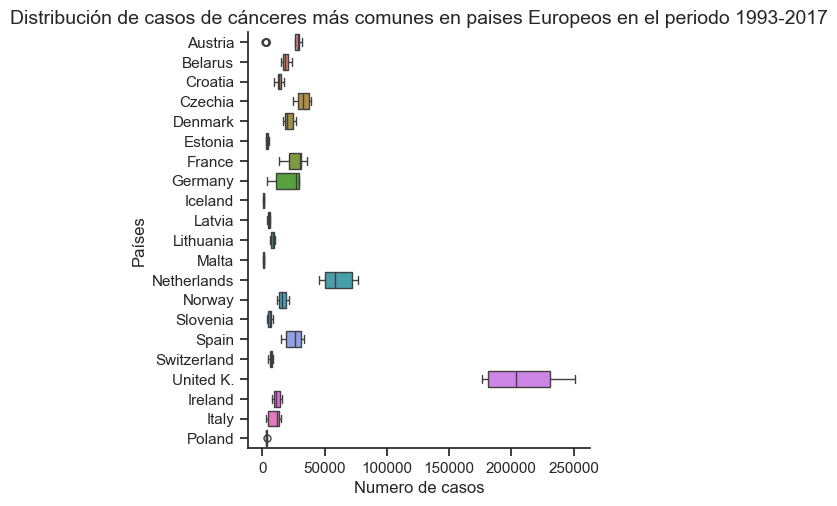

In [212]:
# BoxPlot de los diagnosticos de canceres comunes en cada pais en europa a lo largo del periodo 1993 - 2017
plt.figure(figsize=(15,30))
sns.catplot(x="cases", y="name", kind="box", hue="name", data=casos_totales_europa)
plt.title("Distribución de casos de cánceres más comunes en paises Europeos en el periodo 1993-2017", fontsize=14)
plt.xlabel("Numero de casos", fontsize=12)
plt.ylabel("Países", fontsize=12);


El gráfico de caja muestra como se distribuyen el numero de casos a lo largo del periodo de enlos diferentes países. Se observa en Netherlands (Holanda) y el reino unido (United K.) se diagnostican mayor número de canceres.

Vamos a representar gráficamente como han evolucionado el número de diagnósticos de los cánceres más comunes en los países europeos a lo largo de los años en el periodo 1993-2017.

3) Estudiamos como han evolucionado el número de cánceres diagnostidados en cada uno de los países de Europa

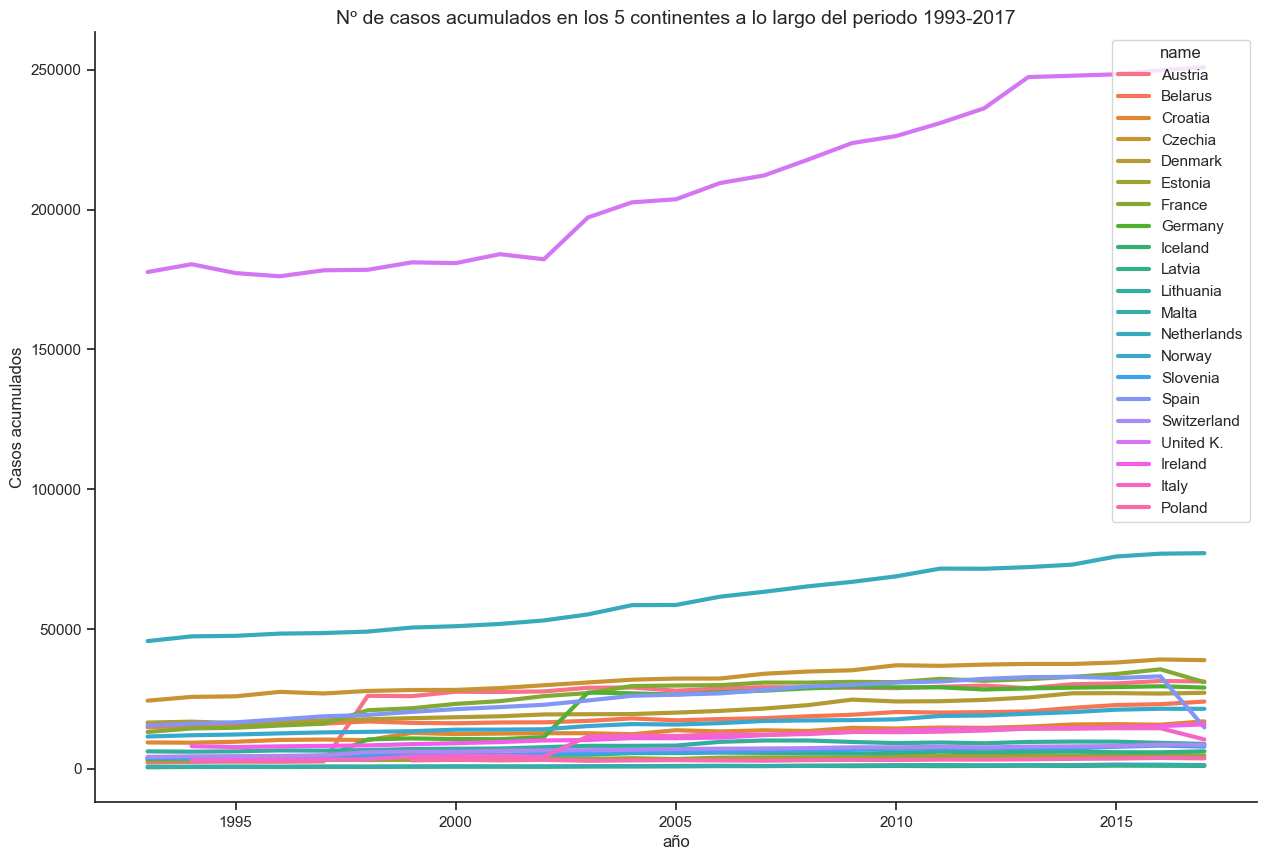

In [213]:
# Gráfico de línea del número de casos diagnosticados de canceres comunes por pais en europa a lo largo del periodo 1993 - 2017

plt.figure(figsize=(15,10))
sns.lineplot(data=casos_totales_europa,
             x="year",
             y="cases",
             hue="name",
            linewidth = 3)
plt.title("Nº de casos acumulados en los 5 continentes a lo largo del periodo 1993-2017", fontsize=14)
plt.xlabel("año", fontsize=12)
plt.ylabel("Casos acumulados", fontsize=12);


El análisis gráfico muestra como el Reino Unido y Holanda son los países donde más casos de los 5 tipos de cánceres se han diagnosticado en el periodo entre 1993 y 2017. Además se observa una tendencia en el aumento de casos en el periodo señalado en varios países.

In [200]:
# Vamos a modificar los valores de edad para que no haya tantos diferentes

def rango_etario(x):
    if x == "0-4" or x == "5-9" or x == "10-14":
        return "0-15"
    elif x == "15-19" or x == "20-24" or x == "25-29":
        return "15-29"
    elif x == "30-34" or x == "35-39" or x == "40-44" or x == "45-49":
        return "30-49"
    elif x == "50-54" or x == "55-59" or x == "60-64" or x == "65-69":
        return "50-69"
    else:
        return ">70"
    

cancer_europe["edad"] = cancer_europe["edad"].apply(rango_etario)

### Análisis de los datos de Reino Unido y Holanda

Dado el alto número de casos en Reino Unido y Holanda, vamos a estudiar como se distribuyen los promedios de casos por año para cada uno de los 5 tipos de cánceres más comunes. Primero lo analizaremos por edad y sexo, y después analizaremos como ha evolucionado a lo largo de los años del periodo 1993-2017.

In [201]:
# Comenzamos por crear dos dataFrames separados para cada uno de los países

cancer_uk = cancer_europe[cancer_europe["name"] == "United K."]

cancer_hol = cancer_europe[cancer_europe["name"]== "Netherlands"]

In [202]:
# Calculamos el numero de casos por tipo de cancer, edad y año  en UK y Netherlands

casos_UK = cancer_uk.groupby(["cancer_label", "edad", "year","sexo"])[["cases"]].sum().reset_index()

casos_ned = cancer_hol.groupby(["cancer_label", "edad", "year","sexo"])[["cases"]].sum().reset_index()

### Análisis de los datos en Reino Unido

1) Analizamos el número de casos acumulados a lo largo del periodo 1993-2017 en el Reino Unido para cada uno de los cánceres más comunes en los diferentes rangos etarios.

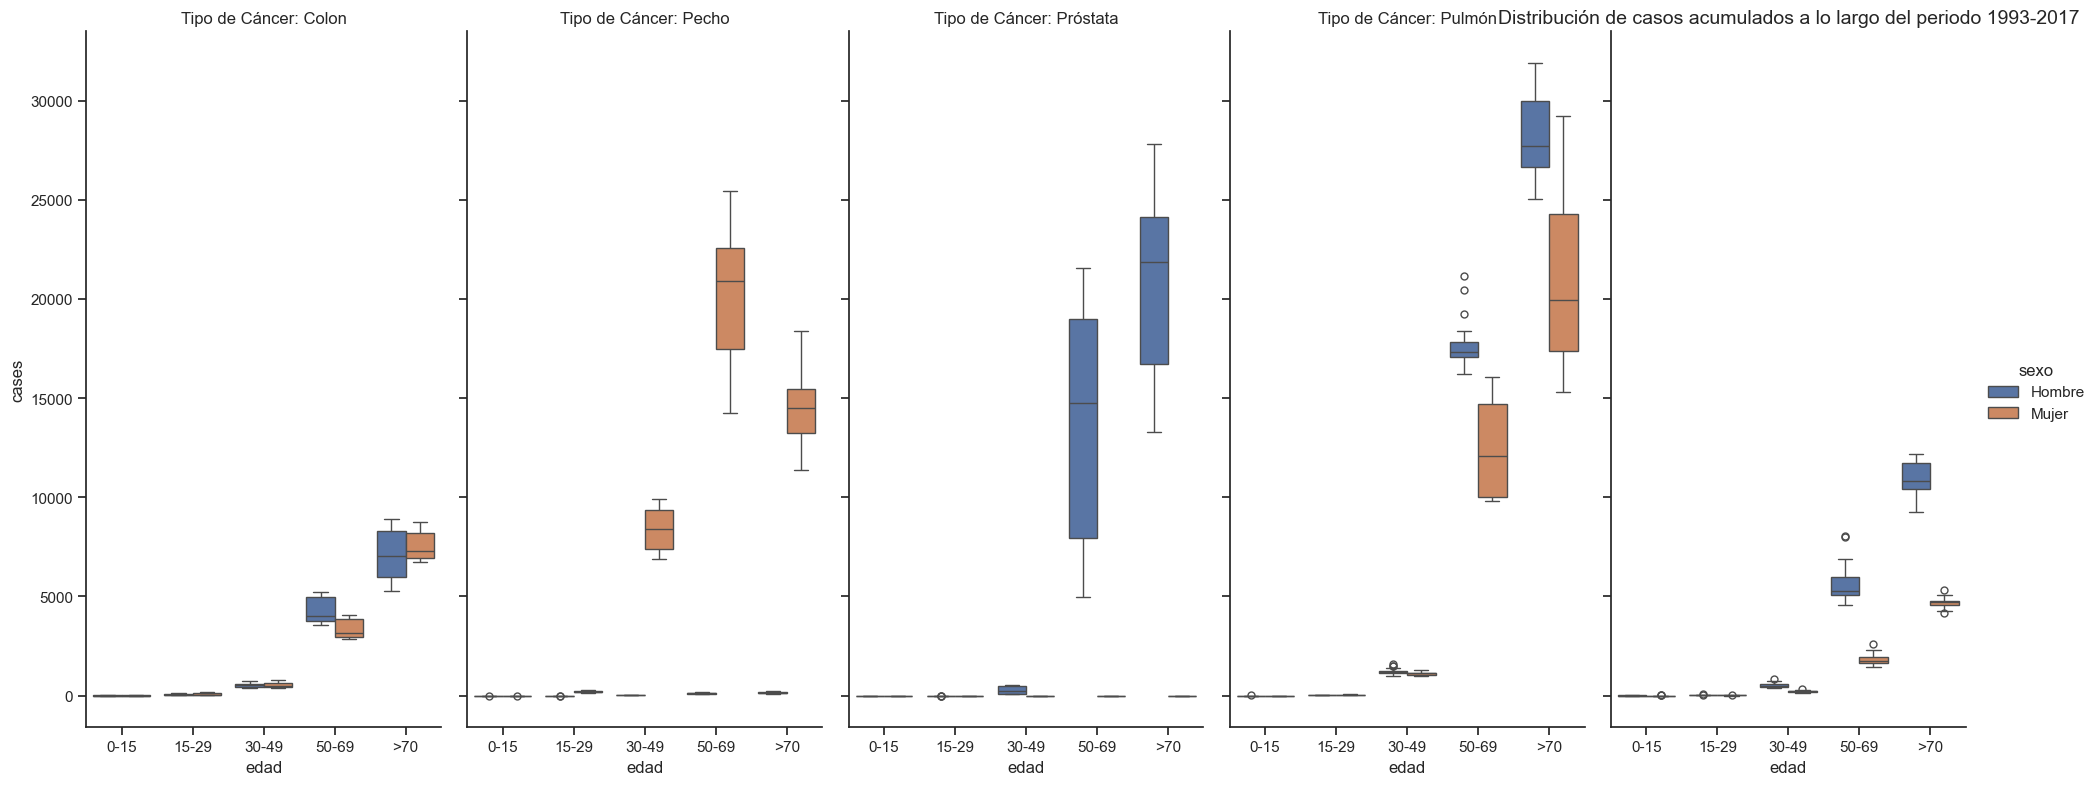

In [ ]:
# Representamos gráficamente el número de casos a lo largo de los años para cada sexo y edad, 
# en cada tipo de cáncer en UK

a = sns.catplot(x="edad",
            y="cases",
            hue="sexo",
            col="cancer_label",
            kind = "box",
            data=casos_UK,
            height=8,
            aspect=0.5)
a.set_titles("Tipo de Cáncer: {col_name}")
a;

Podemos observar en los gráficos que en todos los tipos de cancer el número de casos aumenta con la edad.
Además es de destacable que el número de cánceres de pecho diagnosticados en hombres es 
prácticamente 0. Como es lógico, no existen casos de cáncer de próstata en mujeres. La mayor variabilidad en el número de casos a lo largo del periodo ocurrió en los diagnosticados de cáncer de próstata.

2) Estudiamos la evolución de casos diagnosticados de cada tipo de cáncer en Reino Unido a lo largo del periodo 1993-2017

In [204]:
# Estudiamos la evolución de los casos diagnosticados de cada tipo de cancer en el periodo
# 1993-2017 en UK

tipo_cancer_uk = cancer_uk.groupby(["cancer_label", "year"])[["cases"]].sum().reset_index()

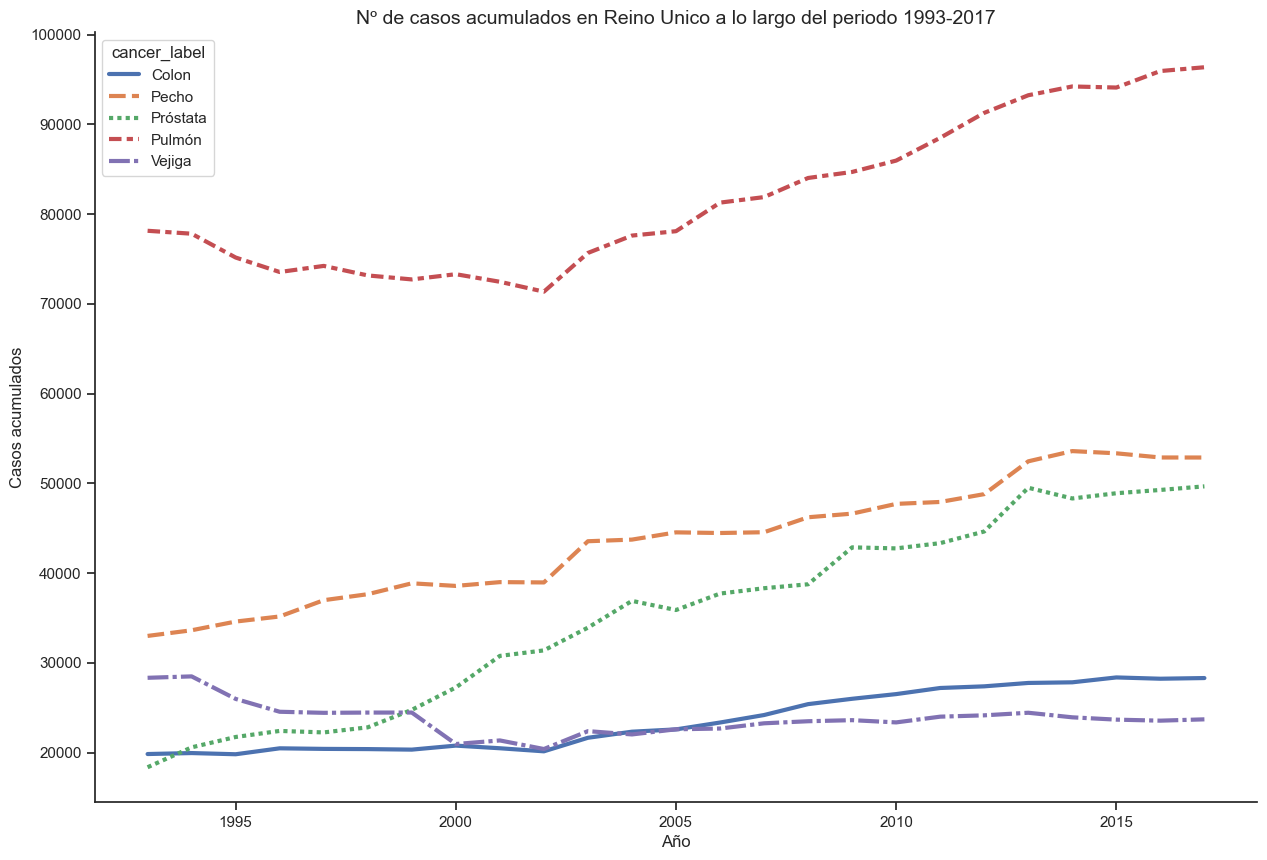

In [215]:
# Análisis gráfico del promedio de casos diagnosticados de los diferentes tipos de cáncer en 
# en el periodo 1993-2017 en UK

plt.figure(figsize=(15,10))
sns.lineplot(data=tipo_cancer_uk,
             x="year",
             y="cases",
             hue="cancer_label",
             style= "cancer_label",
             errorbar=None,
            linewidth = 3)
plt.title("Nº de casos acumulados en Reino Unico a lo largo del periodo 1993-2017", fontsize=14)
plt.xlabel("Año", fontsize=12)
plt.ylabel("Casos acumulados", fontsize=12);

Podemos observar que el número de casos aumenta a lo largo del periodo en todos los tipos de cáncer
excepto en el de vejiga.

### Análisis de los datos en Holanda

1) Analizamos el número de casos acumulados a lo largo del periodo 1993-2017 en el Reino Unido para cada uno de los cánceres más comunes en los diferentes rangos etarios.

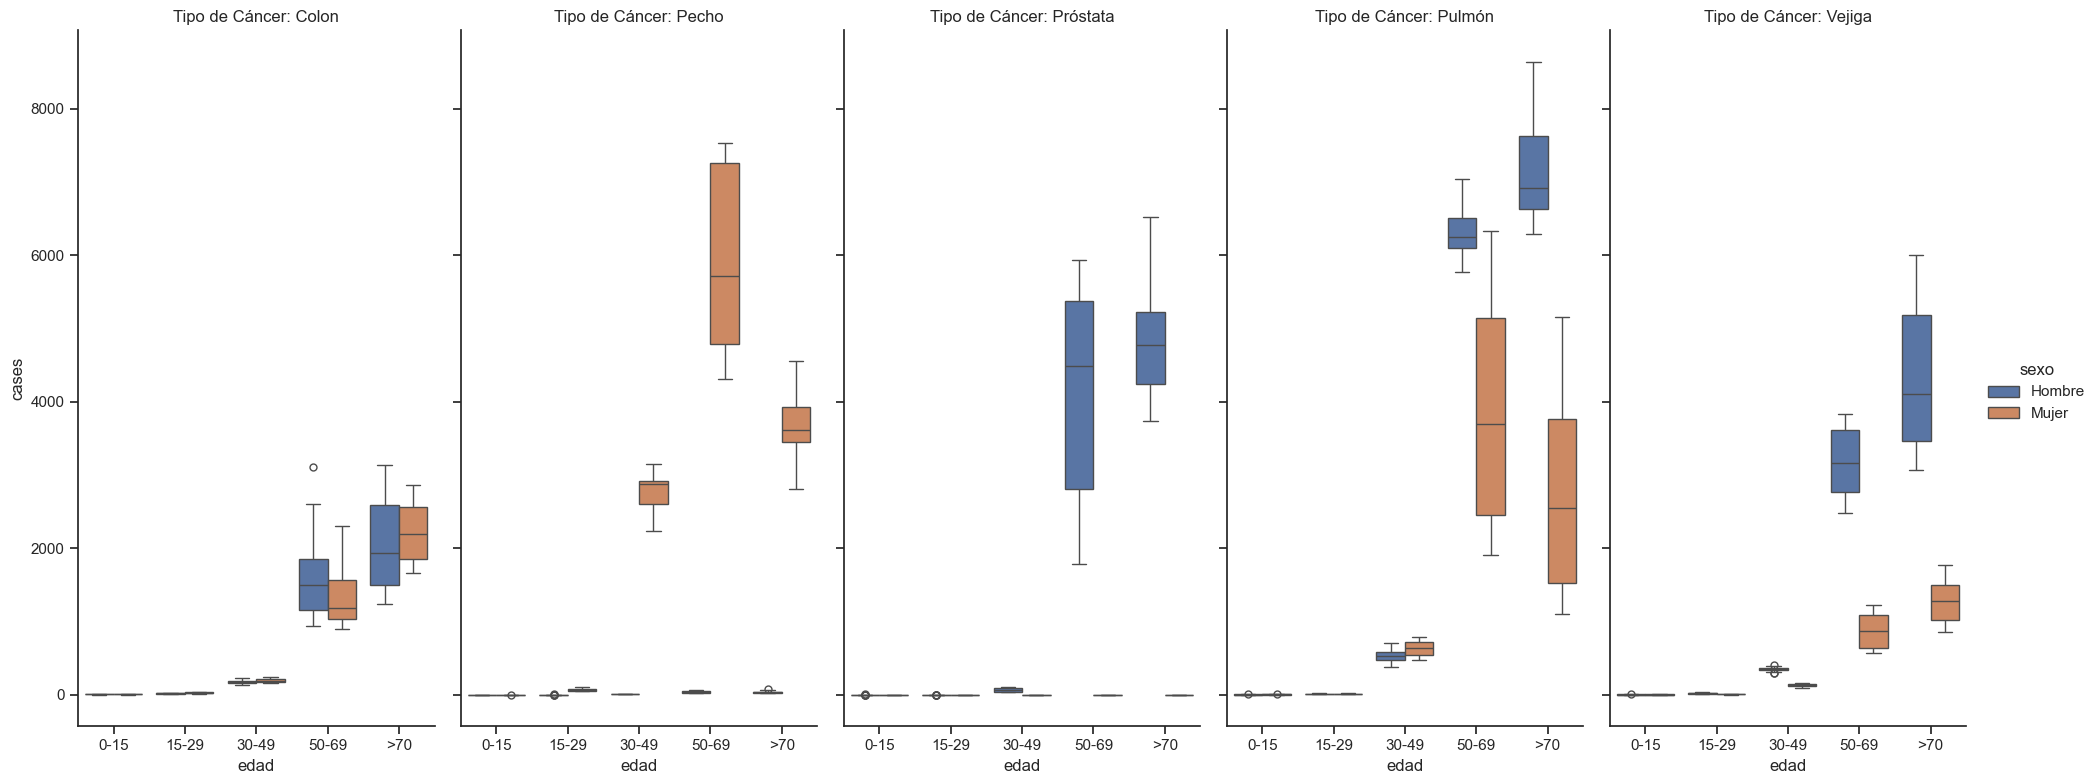

In [207]:
# Representamos gráficamente el número de casos a lo largo de los años para cada sexo y edad, 
# en cada tipo de cáncer en Holanda

b = sns.catplot(x="edad",
            y="cases",
            hue="sexo",
            col="cancer_label",
            kind = "box",
            data=casos_ned,
            height=8,
            aspect=0.5)
b.set_titles("Tipo de Cáncer: {col_name}")
b;

Al igual que en UK vemos como el número de casos diagnosticados de los diferentes tipos de cáncer
se acumulan en los rangos de edad a partir de 30 años. También se observa la dispariedad de cifras 
entre hombres y mujeres en los casos de cánceres de hombres y mujeres.

2) Estudiamos la evolución de casos diagnosticados de cada tipo de cáncer en Reino Unido a lo largo del periodo 1993-2017

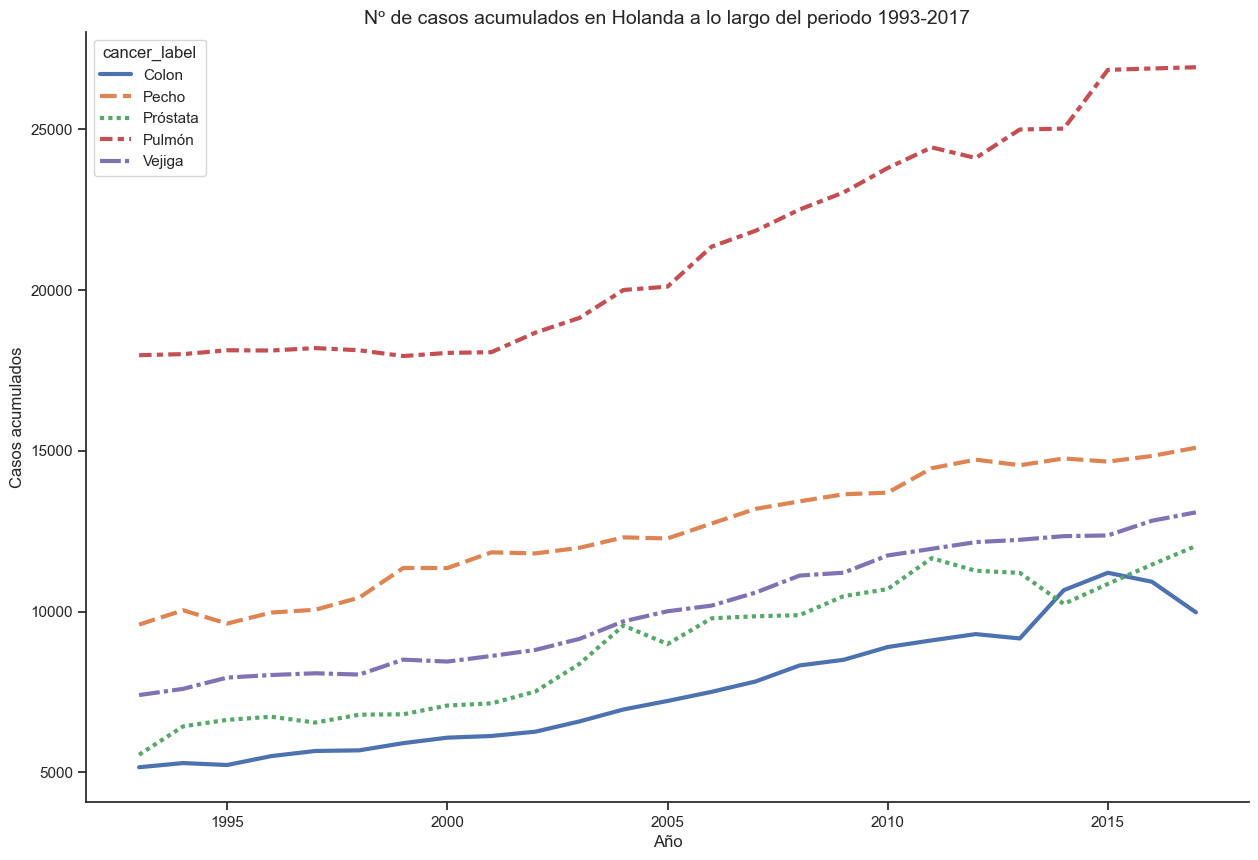

In [216]:
# Estudiamos la evolución del número de casos diagnosticados de cada tipo de cancer en el periodo
# 1993-2017 en Holanda

tipo_cancer_hol = cancer_hol.groupby(["cancer_label", "year"])[["cases"]].sum().reset_index()
tipo_cancer_uk

plt.figure(figsize=(15,10))
sns.lineplot(data=tipo_cancer_hol,
             x="year",
             y="cases",
             hue="cancer_label",
             style= "cancer_label",
            linewidth = 3)
plt.title("Nº de casos acumulados en Holanda a lo largo del periodo 1993-2017", fontsize=14)
plt.xlabel("Año", fontsize=12)
plt.ylabel("Casos acumulados", fontsize=12);

En el gráfico se observa como en Holanda el número de casos de todos los cánceres analizados  han 
aumentado a lo largo del periodo 1993-2017.

## Conclusión

- Existen diferencias en la incidencia del cáncer entre continentes en el periodo 1993-2017. Aun así ls información está my sesgada debido a que el número de países que contribuyen con información en cada continente presenta una desigualdad bastante pronunciada.
- El número de casos acumulados a nivel global es mayor en el caso de los cánceres de pulmón, pecho, próstata y vejiga. Además parece existir cierta tendencia en alza en el número de casos acumulados a lo largo del periodo estudiado.
- Los tumores más comunes en Europa son de pulmón, pecho, próstata, vejiga y colon.
- Los países con mayor número de casos acumulados de los tumores más comunes son el Reino Unido y Holanda.
- El número de casos de los tumores mas comunes en Reino Unido y Holanda aparecen presentan las cifras más altas en rangos de edad superiores a los 30 años.
- El número de casos diagnosticados de los tipos de cánceres más comunes muestran una tendencia en alza en Europa en el periodo de años estudiado.

